<a href="https://colab.research.google.com/github/rdesarz/multi_object_tracking/blob/develop/yolov3_object_detection_colab_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection based on Yolo V3
This notebook is largerly inspired by the following tutorials: https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/. The main goal is to try to use Yolo v3 model to detect and classify object in a scene. 

## Environment setup
The next step are required to configure properly the environment



In [1]:
from google.colab import drive
from google.colab import files
import os

# upload ssh key
os.chdir("/content")
uploaded = files.upload()
!rm -rf /root/.ssh
!mkdir /root/.ssh
!tar xvzf ssh.tar.gz
!cp rsa_github/* /root/.ssh && rm -rf ssh-colab 
!chmod 700 /root/.ssh
!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 664 /root/.ssh/known_hosts

Saving ssh.tar.gz to ssh.tar.gz
rsa_github/
rsa_github/config
rsa_github/id_rsa_colab
rsa_github/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-76c80caa
# github.com:22 SSH-2.0-babeld-76c80caa
# github.com:22 SSH-2.0-babeld-76c80caa


Install objdetect package

In [2]:
!pip install --upgrade git+ssh://git@github.com/rdesarz/multi_object_tracking.git

  Cloning ssh://****@github.com/rdesarz/multi_object_tracking.git to /tmp/pip-req-build-3u8x8gn6
  Running command git clone -q 'ssh://****@github.com/rdesarz/multi_object_tracking.git' /tmp/pip-req-build-3u8x8gn6
  Created wheel for objdetect: filename=objdetect-0.0.1-cp36-none-any.whl size=8542 sha256=5a4f1a092f3c1c3a36205941664218627cd3340e72f51221ddb86a12e2bd85ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-ysep14x6/wheels/eb/07/9a/129147f96d97b52a2452f62a9074495d8bca0bab314f3475c4
Successfully built objdetect


In [3]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

webcam_input_html = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def get_camera_input(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(webcam_input_html % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

frame = get_camera_input()

In [4]:
import objdetect.yolo.model as yolo_model

# Download the weights of yolov3 model
!wget  https://pjreddie.com/media/files/yolov3.weights
model = yolo_model.make_yolov3_model()
# load the model weights
weight_reader = yolo_model.WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)

Using TensorFlow backend.


--2020-04-21 11:41:01--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   234KB/s    in 26m 14s 

2020-04-21 12:07:17 (154 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of conv

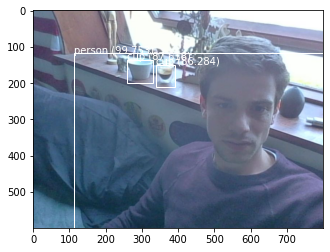

In [5]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from objdetect.yolo.preprocessing import process_image
from objdetect.yolo.postprocessing import do_nms, correct_yolo_boxes, decode_netout, get_boxes
from objdetect.yolo.output import draw_boxes

# Setup model variables
input_shape = (416, 416)
threshold = 0.6
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]

# preprocess image to input it in the network
image, image_w, image_h = process_image(frame, input_shape)
# make prediction
yhat = model.predict(image)
boxes = list()
for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], threshold, input_shape[0], input_shape[1])
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_shape[0], input_shape[1])
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, threshold)
# draw the resulting prediction
draw_boxes(frame, v_boxes, v_labels, v_scores)